# GradCAM from Captum Library implementation

In [1]:
from torchvision.models import resnet
import torchvision.transforms as transforms
from torchvision import datasets

import torch
from torch.utils.data import DataLoader, Dataset
from captum.attr import GuidedGradCam, IntegratedGradients

import kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt

from utils.plot import plot_random_six_images, plot_idx_labeled
from utils.metric_functions import test_on_given_idx

/home/franio/Desktop/Explainable_AI/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
# Download latest version
DATA_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
IMG_PATH = os.path.join(DATA_PATH, "images", "Images")
ANNOTATION_PATH = os.path.join(DATA_PATH, "annotations", "Annotations")

print("Path to dataset files:", DATA_PATH)

dataset = datasets.ImageFolder(root=IMG_PATH)

Path to dataset files: /home/franio/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


### Transform, set and Loader
Normalization is done with standard image net $\mu$ and $\sigma$

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])


# Images and Predictions

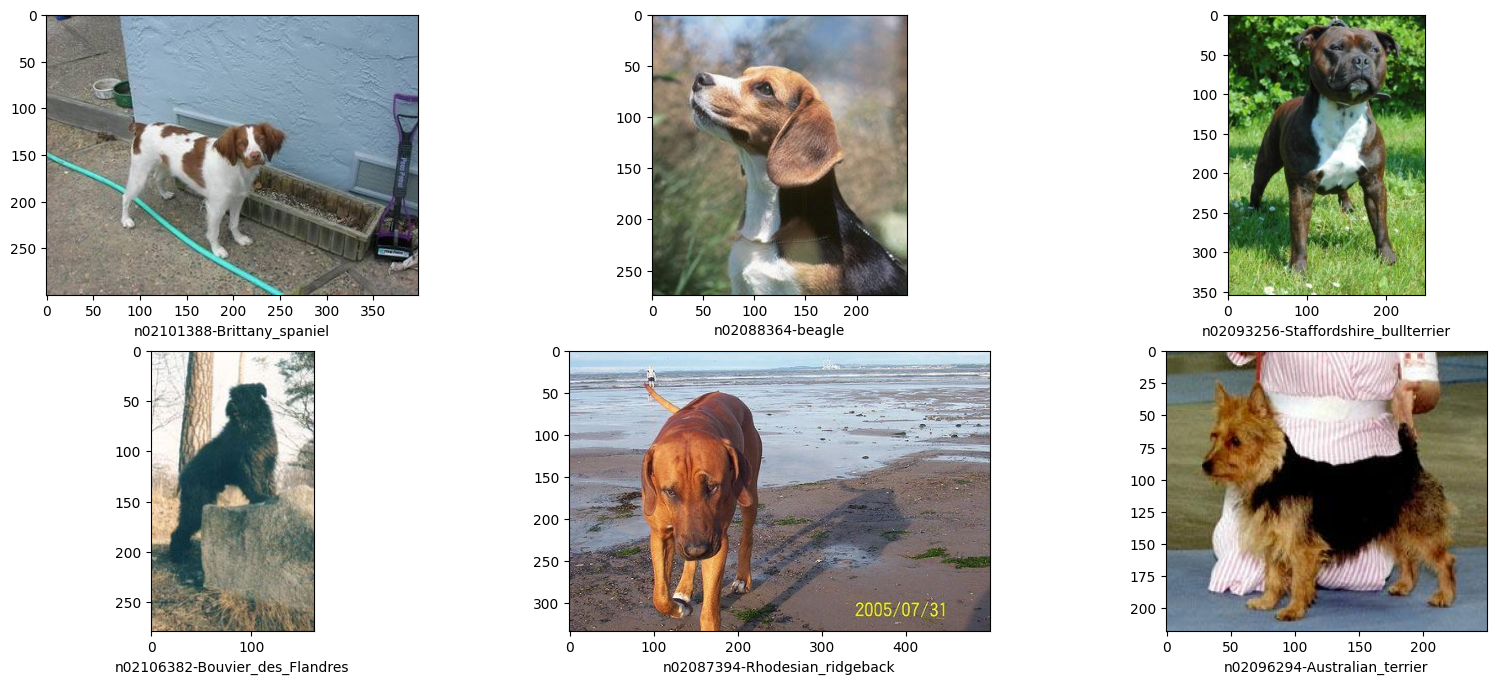

In [4]:
idx = plot_random_six_images(dataset, dataset.classes)

## Loding Model and Prediction

In [5]:
MODEL_NAME = 'resnet18_dogs_5_epochs'

net_model = resnet.resnet18()
net_model.load_state_dict(torch.load(os.path.join('models', f"{MODEL_NAME}.pth"), weights_only=True))

preds, df = test_on_given_idx(dataset, net_model,transform, idx=idx)

df

Idx                           True_Label  \
0  11366           n02101388-Brittany_spaniel   
1   2103                     n02088364-beagle   
2   5161  n02093256-Staffordshire_bullterrier   
3  14132       n02106382-Bouvier_des_Flandres   
4   1652        n02087394-Rhodesian_ridgeback   
5   7626         n02096294-Australian_terrier   

                            Predicted_Label  
0                n02101388-Brittany_spaniel  
1                          n02088364-beagle  
2  n02093428-American_Staffordshire_terrier  
3            n02106382-Bouvier_des_Flandres  
4                         n02090379-redbone  
5              n02096294-Australian_terrier

array([11366,  2103,  5161, 14132,  1652,  7626])

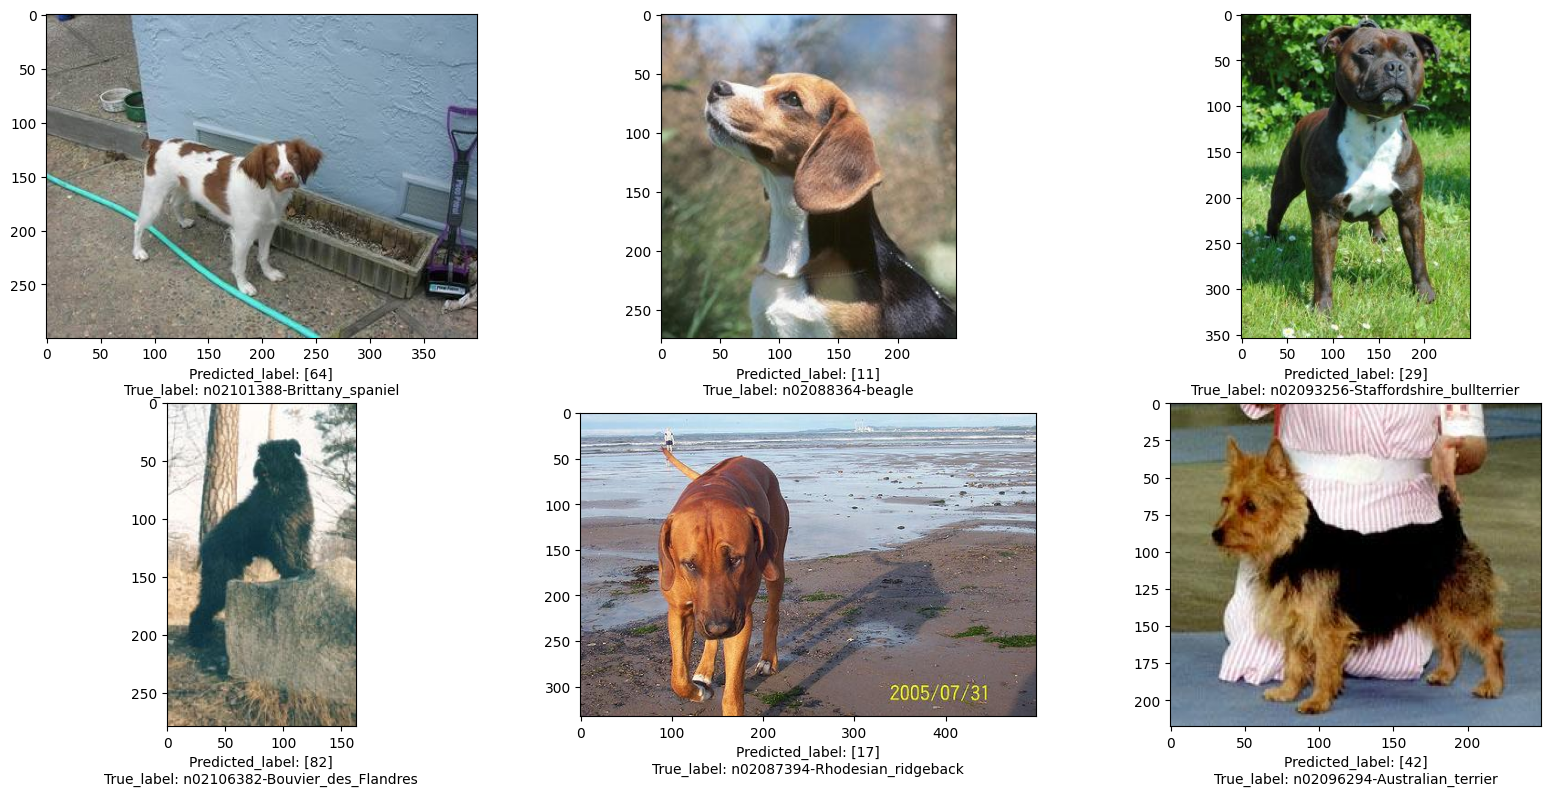

In [6]:
plot_idx_labeled(idx,preds,dataset)

# GradCAM

In [7]:
guided_gc = GuidedGradCam(net_model.cpu(), net_model.layer4)
ig = IntegratedGradients(net_model.cpu(), multiply_by_inputs=True)




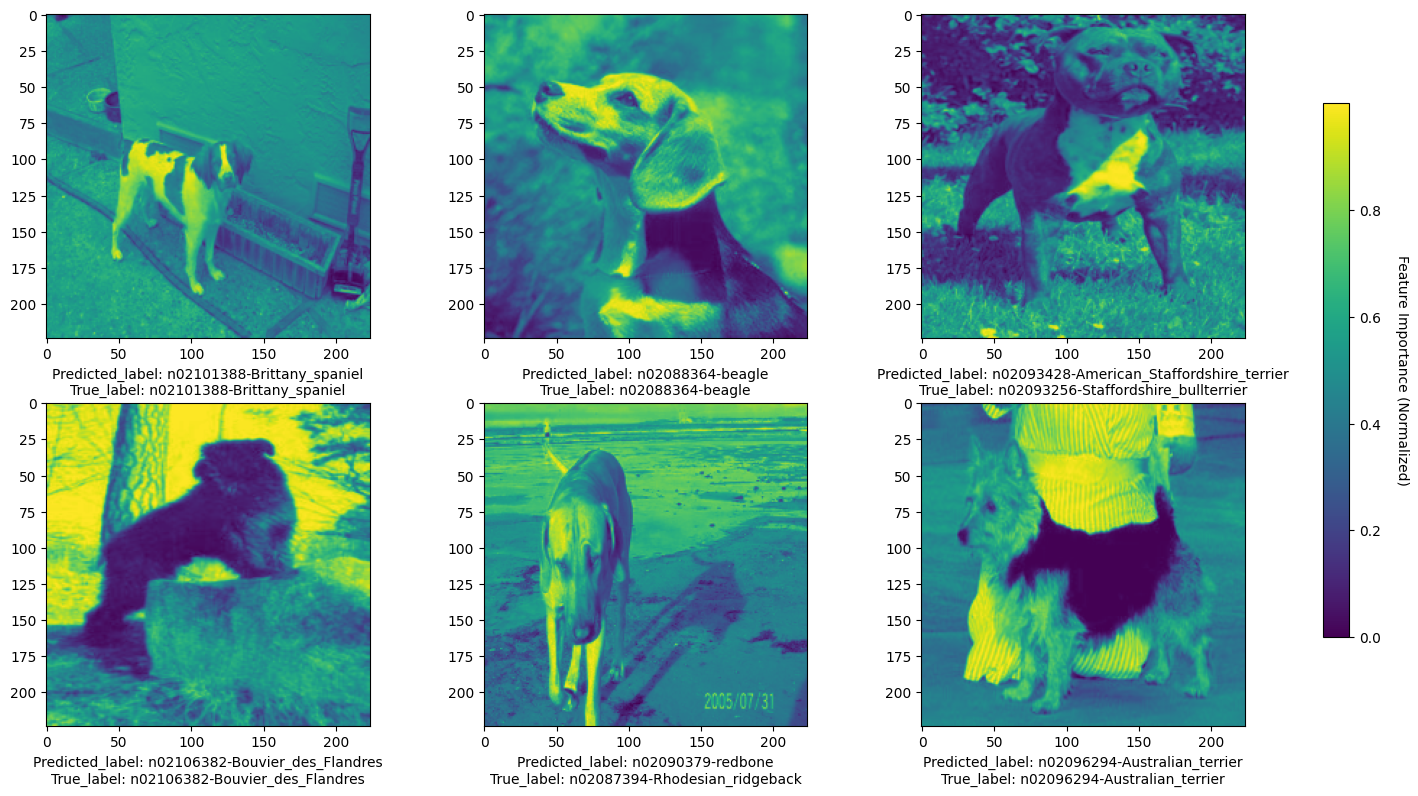

In [31]:
import warnings
import PIL.Image


def plot_with_function(idx, preds, dataset, func, trnsform):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fig, axes = plt.subplots(2,3,figsize=(20, 8))
    fig.subplots_adjust(top=1)

    for i, k in enumerate(idx):
        img, class_num = dataset[k]
        img_tensor = (transform(img).unsqueeze(0)).cpu()
        img_tensor.requires_grad_(True)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            attribution = func(img_tensor, target=int(preds[i][0]))

        attribution_np = attribution.detach().cpu().numpy()
        attribution_np = np.max(np.abs(attribution_np), axis=0)


        min_val = np.min(attribution_np)
        max_val = np.max(attribution_np)

        if max_val > min_val:
            attribution_np = (attribution_np - min_val) / (max_val - min_val)

        attribution_show = attribution_np[0]
        numpy_img = (img_tensor.detach().numpy()).squeeze()

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        original_img_np = numpy_img*std.reshape(-1,1,1) + mean.reshape(-1,1,1)
        original_img_np = original_img_np[0]
        # print(attribution_show)

        ax = axes[i//3][np.mod(i,3)]
        im = ax.imshow(original_img_np)
        #ax.imshow(attribution_show, cmap='plasma',alpha=0.4, interpolation='none', vmin=0, vmax=attribution_show.max())
        ax.set_xlabel(f"Predicted_label: {dataset.classes[preds[i][0]]}\n"
                      f"True_label: {dataset.classes[class_num]}")

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.75)
    cbar.set_label('Feature Importance (Normalized)', rotation=270, labelpad=20)


plot_with_function(idx, preds, dataset, guided_gc.attribute, trnsform=transform)